# Primordial non-Gaussianity examples

In this notebook we will show how to perform PNG fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 1e-4
volume = 1e9

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## BAO likelihood

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import ObservedTracerPowerSpectrumMultipoles
from desilike.likelihoods import GaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
# Set damping sigmas to zero, as data follows linear pk
# Fix some broadband parameters (those with k^{-3} and k^{-2}) to speed up calculation in this notebook
for param in theory.params.select(basename=['sigma*', 'al*_-3', 'al*_-2']):
    param.value = 0.
    param.fixed = True
observable = ObservedTracerPowerSpectrumMultipoles(data=data, mocks=mocks,
                                                   klim={0: [0.005, 0.2], 2: [0.005, 0.2]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                   kstep=0.01, theory=theory)
likelihood = GaussianLikelihood(observables=[observable])

setup_logging()
likelihood()  # just to initialize

[000000.10] [0/1] 12-01 14:33  GaussianLikelihood        INFO     Covariance matrix with 40 points built from 1000 observations.
[000000.10] [0/1] 12-01 14:33  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9590.
[000000.11] [0/1] 12-01 14:33  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.11] [0/1] 12-01 14:33  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.11] [0/1] 12-01 14:33  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.11] [0/1] 12-01 14:33  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.11] [0/1] 12-01 14:33  absl                      WARNING  No GPU/TPU found, falling back to CP

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


-17.268139827508737

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=3)

[000000.69] [0/1] 12-01 14:33  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


In [4]:
print(profiler.profiles.to_stats(tablefmt='pretty'))

+--------------+--------+---------+-------+
| chi2 = 24.54 | varied | bestfit | error |
+--------------+--------+---------+-------+
|     qpar     |  True  |  1.030  | 0.013 |
|     qper     |  True  |  1.027  | 0.023 |
|      b1      |  True  |  2.06   | 0.11  |
|    al0_-1    |  True  |   25    |  66   |
|    al0_0     |  True  |  -700   | 1200  |
|    al0_1     |  True  |  1900   | 5200  |
|    al2_-1    |  True  |   17    |  25   |
|    al2_0     |  True  |  -200   |  540  |
|    al2_1     |  True  |   800   | 2300  |
+--------------+--------+---------+-------+


array([<AxesSubplot:ylabel='$\\alpha_{\\parallel}$'>,
       <AxesSubplot:ylabel='$\\alpha_{\\perp}$'>], dtype=object)

[000017.18] [0/1] 12-01 14:33  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000017.18] [0/1] 12-01 14:33  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000017.21] [0/1] 12-01 14:33  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000017.22] [0/1] 12-01 14:33  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


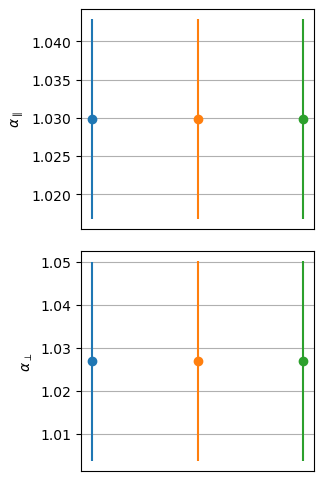

In [5]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiler.profiles, params=['qpar', 'qper'])

array([<AxesSubplot:ylabel='$k \\Delta P_{0}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>,
       <AxesSubplot:xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$k \\Delta P_{2}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>],
      dtype=object)

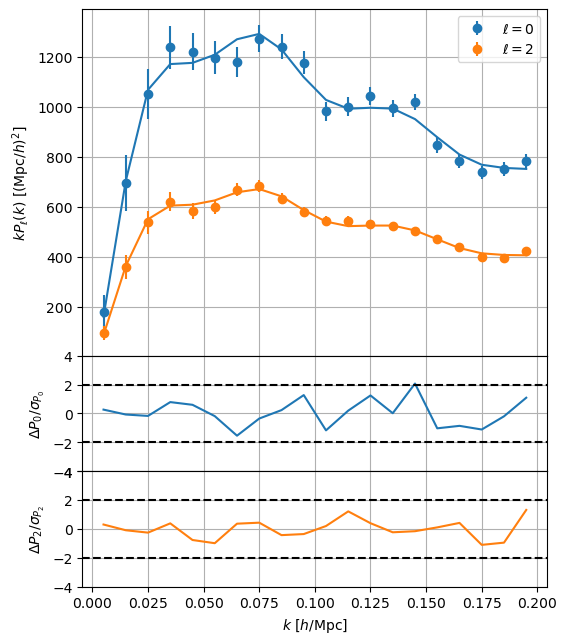

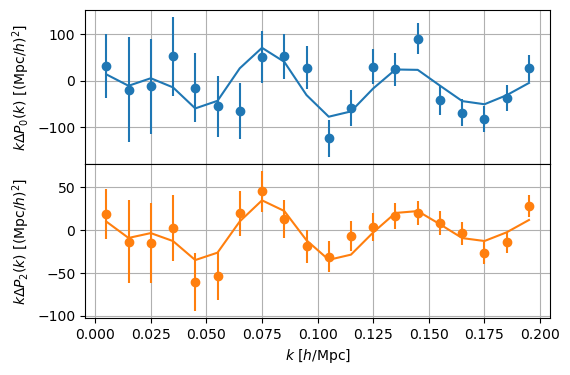

In [6]:
likelihood(**profiler.profiles.bestfit.choice(params=likelihood.varied_params))
observable.plot()
observable.plot_bao()

## Detection level

In [7]:
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso')
theory.update(template=template, wiggle=False)
#likelihood()
#print(likelihood.varied_params)
#observable.plot()

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000017.87] [0/1] 12-01 14:33  GaussianLikelihood        INFO     Covariance matrix with 40 points built from 1000 observations.
[000017.88] [0/1] 12-01 14:33  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9590.
[000017.95] [0/1] 12-01 14:33  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


In [8]:
theory.update(wiggle=True)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000105.55] [0/1] 12-01 14:35  GaussianLikelihood        INFO     Covariance matrix with 40 points built from 1000 observations.
[000105.55] [0/1] 12-01 14:35  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9590.
[000105.56] [0/1] 12-01 14:35  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
+--------------+--------+---------+-------+
| chi2 = 24.56 | varied | bestfit | error |
+--------------+--------+---------+-------+
|     qiso     |  True  |  1.030  | 0.013 |
|      b1      |  True  |  2.070  | 0.098 |
|    al0_-1    |  True  |   25    |  66   |
|    al0_0     |  True  |  -700   | 1200  |
|    al0_1     |  True  |  2100   | 5000  |
|    al2_-1    |  True  |   18    |  25   |
|    al2_0     |  True  |  -160   |  430  |
|    al2_1     |  True  |   600   | 1800  |
+--------------+--------+---------+-------+


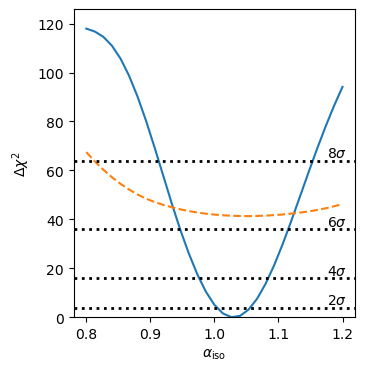

In [9]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[2, 4, 6, 8])
# Orange curve is no-wiggle:
# Some qiso information is picked up by the broadband because we did not include enough broadband terms

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [10]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000191.49] [0/1] 12-01 14:36  ZeusSampler               INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000191.90] [0/1] 12-01 14:36  root                      INFO     Initialising ensemble of 20 walkers...
[000776.61] [0/1] 12-01 14:46  ZeusSampler               INFO     Diagnostics:
[000776.63] [0/1] 12-01 14:46  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.296; not < 0.04.
[000776.64] [0/1] 12-01 14:46  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00674.
[000776.68] [0/1] 12-01 14:46  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0734.
[000776.70] [0/1] 12-01 14:46  ZeusSampler               INFO     - max Geweke is 0.212.
[000776.70] [0/1] 12-01 14:46  ZeusSampler               INFO     - Geweke p-value is 0.0252.
[000776.77] [0/1] 12-01 14:46  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 13.8.
[000777.22] [0/1] 12-01 14:46  root                      INFO     Initialising ensemble of 20 walkers...
[001352.19] [0/1] 12-01 14:55  ZeusSampler               I

[005473.93] [0/1] 12-01 16:04  ZeusSampler               INFO     - Geweke p-value is 0.0568.
[005474.00] [0/1] 12-01 16:04  ZeusSampler               INFO     - (1350 iterations / integrated autocorrelation time) (reliable) is 83.4.
[005474.00] [0/1] 12-01 16:04  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.34.
[005474.37] [0/1] 12-01 16:04  root                      INFO     Initialising ensemble of 20 walkers...
[006105.61] [0/1] 12-01 16:15  ZeusSampler               INFO     Diagnostics:
[006105.62] [0/1] 12-01 16:15  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.121; not < 0.04.
[006105.64] [0/1] 12-01 16:15  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00866.
[006105.71] [0/1] 12-01 16:15  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0609.
[006105.72] [0/1] 12-01 16:15  ZeusSampler               INFO     - max Geweke is 0.305.
[006105.72] [0/1] 12-01 1

Traceback (most recent call last):
  File "/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/zeus/fwrapper.py", line 24, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py", line 56, in wrapper
    toret[mask] = func(self, values)
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py", line 136, in logposterior
    toret[mask] = self.loglikelihood(values[mask])
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py", line 56, in wrapper
    toret[mask] = func(self, values)
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py", line 107, in loglikelihood
    self.pipeline.mpicalculate(**points.to_dict())
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py", line 157, in mpicalculate
    self.calculate(**{name: value[ivalue] for name, value in params.items()

KeyboardInterrupt: 

In [ ]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

In [ ]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})